# Scene Text Recognition
> Detecting and comprehending text in images using EAST and Tesseract models

- toc: false
- badges: true
- comments: false
- categories: [SceneText, OCR, ComputerVision]
- image:

The EAST (which stands for Efficient and Accuracy Scene Text detection) text detector is a powerful pipeline for accurate and fast text detection. The model is an FCN (a single deep neural net) that directly predicts the bounding boxes for the words/text lines present in the input image (with arbitrary orientations), thereby eliminating unnecessary preprocessing steps (such as candidate aggregation and word partitioning). It's only required to apply thresholding and NMS on predicted geometric shapes, as the post-processing steps. The following diagram shows the EAST pipeline:

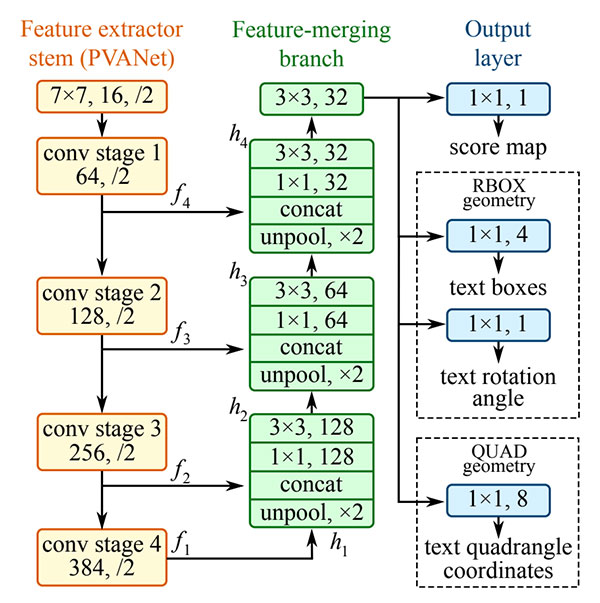

Optical Character Recognition (OCR)/ text recognition refers to the task of extracting text from images. In this recipe, we will use Tesseract v4 for text recognition. Tesseract v4, by default, uses an LSTM-based recognition engine. The pytesseract module just provides a wrapper over the Tesseract command-line tool (we can specify the command-line arguments with the config argument).

In [ ]:
#hide-output
!pip install pytesseract
!sudo apt-get update
!sudo apt-get install tesseract-ocr
!sudo apt-get install libtesseract-dev
!pip install tesseract
!pip install tesseract-ocr

  Created wheel for pytesseract: filename=pytesseract-0.3.7-py2.py3-none-any.whl size=13945 sha256=b143d05d4cbb6e2f577c649bf2df587aecf68156a5d52cca29c766d590bd3137
  Stored in directory: /root/.cache/pip/wheels/81/20/7e/1dd0daad1575d5260916bb1e9781246430647adaef4b3ca3b3
Successfully built pytesseract
Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 3.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 2.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


In [ ]:
# import the necessary packages
from imutils.object_detection import non_max_suppression
from IPython.display import Image
import numpy as np
import pytesseract
import cv2

In [ ]:
min_confidence = 0.5

In [ ]:
def decode_predictions(scores, geometry):
    '''grab the number of rows and columns from the scores volume, then
    initialize our set of bounding box rectangles and corresponding
    confidence scores
    '''

    (num_rows, num_cols) = scores.shape[2:4]
    rects = []
    confidences = []
 
    # loop over the number of rows
    for y in range(0, num_rows):
        # extract the scores (probabilities), followed by the
        # geometrical data used to derive potential bounding box
        # coordinates that surround text
        scores_data = scores[0, 0, y]
        x_data0 = geometry[0, 0, y]
        x_data1 = geometry[0, 1, y]
        x_data2 = geometry[0, 2, y]
        x_data3 = geometry[0, 3, y]
        angles_data = geometry[0, 4, y]
 
        # loop over the number of columns
        for x in range(0, num_cols):
            # if our score does not have sufficient probability,
            # ignore it
            if scores_data[x] < min_confidence:
                continue
 
            # compute the offset factor as our resulting feature
            # maps will be 4x smaller than the input image
            (offset_x, offset_y) = (x * 4.0, y * 4.0)
 
            # extract the rotation angle for the prediction and
            # then compute the sin and cosine
            angle = angles_data[x]
            cos = np.cos(angle)
            sin = np.sin(angle)
 
            # use the geometry volume to derive the width and height
            # of the bounding box
            h = x_data0[x] + x_data2[x]
            w = x_data1[x] + x_data3[x]
 
            # compute both the starting and ending (x, y)-coordinates
            # for the text prediction bounding box
            end_x = int(offset_x + (cos * x_data1[x]) + (sin * x_data2[x]))
            end_y = int(offset_y - (sin * x_data1[x]) + (cos * x_data2[x]))
            start_x = int(end_x - w)
            start_y = int(end_y - h)
 
            # add the bounding box coordinates and probability score
            # to our respective lists
            rects.append((start_x, start_y, end_x, end_y))
            confidences.append(scores_data[x])
 
    # return a tuple of the bounding boxes and associated confidences
    return (rects, confidences)

In [ ]:
# load the input image and grab the image dimensions
!wget -O img.jpg 'https://images.squarespace-cdn.com/content/53fa7ec2e4b0431f98587b1f/1456357172427-ZSESVHLVMN1BCATDSXDD/image-asset.jpeg?content-type=image%2Fjpeg'

--2020-12-29 08:07:18--  https://images.squarespace-cdn.com/content/53fa7ec2e4b0431f98587b1f/1456357172427-ZSESVHLVMN1BCATDSXDD/image-asset.jpeg?content-type=image%2Fjpeg
Resolving images.squarespace-cdn.com (images.squarespace-cdn.com)... 151.101.0.238, 151.101.64.238, 151.101.128.238, ...
Connecting to images.squarespace-cdn.com (images.squarespace-cdn.com)|151.101.0.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64825 (63K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  63.31K  --.-KB/s    in 0.01s   

2020-12-29 08:07:19 (4.70 MB/s) - ‘img.jpg’ saved [64825/64825]



In [ ]:
im = 'img.jpg'
image = cv2.imread(im)
orig = image.copy()
(origH, origW) = image.shape[:2]

In [ ]:
!wget -O frozen_east_text_detection.pb https://github.com/oyyd/frozen_east_text_detection.pb/blob/master/frozen_east_text_detection.pb?raw=true

--2020-12-29 08:07:22--  https://github.com/oyyd/frozen_east_text_detection.pb/blob/master/frozen_east_text_detection.pb?raw=true
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/oyyd/frozen_east_text_detection.pb/raw/master/frozen_east_text_detection.pb [following]
--2020-12-29 08:07:22--  https://github.com/oyyd/frozen_east_text_detection.pb/raw/master/frozen_east_text_detection.pb
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/oyyd/frozen_east_text_detection.pb/master/frozen_east_text_detection.pb [following]
--2020-12-29 08:07:22--  https://raw.githubusercontent.com/oyyd/frozen_east_text_detection.pb/master/frozen_east_text_detection.pb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.1

In [ ]:
# set the new width and height and then determine the ratio in change
# for both the width and height
width = height = 32*10 #320
(w, h) = (width, height)
rW = origW / float(w)
rH = origH / float(h)
 
# resize the image and grab the new image dimensions
image = cv2.resize(image, (w, h))
(H, W) = image.shape[:2]

# define the two output layer names for the EAST detector model that
# we are interested in -- the first is the output probabilities and the
# second can be used to derive the bounding box coordinates of text
layerNames = [
    "feature_fusion/Conv_7/Sigmoid",
    "feature_fusion/concat_3"]
 
# load the pre-trained EAST text detector
print("loading EAST text detector...")
net = cv2.dnn.readNet('frozen_east_text_detection.pb')

# construct a blob from the image and then perform a forward pass of
# the model to obtain the two output layer sets
b, g, r = np.mean(image[...,0]), np.mean(image[...,1]), np.mean(image[...,2])
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H), (b, g, r), swapRB=True, crop=False)
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)
 
# decode the predictions, then  apply non-maxima suppression to
# suppress weak, overlapping bounding boxes
(rects, confidences) = decode_predictions(scores, geometry)
boxes = non_max_suppression(np.array(rects), probs=confidences)

padding = 0.001 #0.01 #0.5
# initialize the list of results
results = []
 
# loop over the bounding boxes
for (start_x, start_y, end_x, end_y) in boxes:
    # scale the bounding box coordinates based on the respective ratios
    start_x = int(start_x * rW)
    start_y = int(start_y * rH)
    end_x = int(end_x * rW)
    end_y = int(end_y * rH)

    # in order to obtain a better OCR of the text we can potentially
    # apply a bit of padding surrounding the bounding box -- here we
    # are computing the deltas in both the x and y directions
    dX = int((end_x - start_x) * padding)
    dY = int((end_y - start_y) * padding)

    # apply padding to each side of the bounding box, respectively
    start_x = max(0, start_x - dX*2)
    start_y = max(0, start_y - dY*2)
    end_x = min(origW, end_x + (dX * 2))
    end_y = min(origH, end_y + (dY * 2))

    # extract the actual padded ROI
    roi = orig[start_y:end_y, start_x:end_x]

    # in order to apply Tesseract v4 to OCR text we must supply
    # (1) a language, (2) an OEM flag of 4, indicating that the we
    # wish to use the LSTM neural net model for OCR, and finally
    # (3) an OEM value, in this case, 7 which implies that we are
    # treating the ROI as a single line of text
    config = ("-l eng --oem 1 --psm 11")
    text = pytesseract.image_to_string(roi, config=config)
    #print(text)

    # add the bounding box coordinates and OCR'd text to the list
    # of results
    results.append(((start_x, start_y, end_x, end_y), text))

    # sort the results bounding box coordinates from top to bottom
    results = sorted(results, key=lambda r:r[0][1])
 
print(len(results))
# loop over the results
output = orig.copy()
i = 1
for ((start_x, start_y, end_x, end_y), text) in results:
    # display the text OCR'd by Tesseract
    #print("OCR TEXT")
    #print("========")
    print(text)

    # strip out non-ASCII text so we can draw the text on the image
    # using OpenCV, then draw the text and a bounding box surrounding
    # the text region of the input image
    text = "".join([c if ord(c) < 128 else "" for c in text]).strip()
    cv2.rectangle(output, (start_x, start_y), (end_x, end_y), (0, 255, 0), 2)
    cv2.putText(output, text, (start_x, start_y - 20), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)

    # show the output image
    i += 1
    
cv2.imwrite("text_" + im.split('/')[-1], output)

loading EAST text detector...
3
TOW

VOU

OV?



True

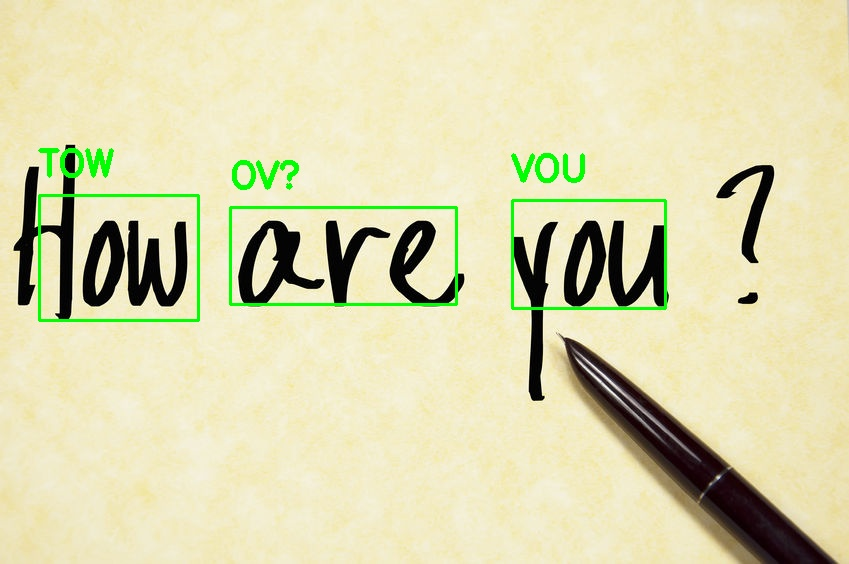

In [ ]:
Image(filename='text_img.jpg') 

Learn more:
- https://www.notion.so/knowledgetree/Scene-Text-Recognition-bea147a555fe41dbbe2ab884a00521ae